# 12 Flower 분류 미니플젝 다시제출
이미지들이 충돌로 깃헙에 보이지 않는거 같아서 다시 제출합니다. 25/12/15

-  기본 결과. accuracy : 0.78
-  목표 : accuracy : 0.85
-  실험3 최종결과 : accuracy : 0.968

실험1.
 - 이미지 사이즈 변경 : 160 - > 224
 - 데이터 증강  
 - 결과: accuracy : 0.75
 - 더 떨어짐.. 이미지 변경이 오히려 노이즈를 키운거같음.


실험2.
- 사이즈 크기는 224 유지. 데이터 증강 삭제
- fine tuning: learning rate 10배 작게 변경, epoch 15회로 증가
- drop out 추가로 과적합 방지
- 결과 :accuracy : 0.906
- 높은 정확도 향상.

실험3.
- 실험 2에서  fine tuning이 주요한 상승 요인으로 보여서 더 극단적으로 추가실험 진행

- learning rate를 실험2의 절반, epoch를 25회로 변경
- 결과 : accuracy : 0.968


#### 회고
실험때마다 정확도가 올라서 놀랐다.
- 릴라쿠마 이미지는 3차실험에도 분류를 못했다. 꽃이미지 이외에 라벨을 생성하면 예외처리 할수도 있을거 같다. 꽃이미지가 더 많이 필요하다.
- learning rate을 낮추면 정확도를 급격히 끌어올리면서, dropout으로 과적합 방지를 해주는 tuning의 결과가 매우 좋았다.
- epoch을 계속해서 늘려주면 val-acc와 acc가 미세하게 선형적으로 증가한다. 훈련시간을 많이 확보한다면, 더 좋은 모델도 만들수 있을거같다.
- val loss는 시간이 epoch을 늘려주어도 고정이다. loss는 지속적으로 감소한다.

## Step 1. 데이터셋 내려받기
이번에는 tensorflow_datasets 에 포함된 tf_flowers 데이터를 사용해 보겠습니다. tf_flowers 데이터에 대한 정보는 다음에서 확인해볼 수 있습니다.
tfds.load를 활용하여 데이터셋을 다운받으세요.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    # 여기 경로 바꿔주시고
    data_dir='/content/drive/MyDrive/Colab Notebooks/Data/catdog',
    # 여기 True로 변경
    download=True,
    with_info=True,
    as_supervised=True,
)

## Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기
이미지를 모두 같은 크기로 formatting 한 후, train_batches, validation_batches, test_batches를 준비합니다.

In [ ]:
# # 데이터 증강
# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     return image, label

In [ ]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기 (원본사이즈)

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
# train = raw_train.map(format_example).map(augment)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
# train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# validation_batches = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
# 마지막블록만 학습가능하게 풀기
base_model.trainable = True

In [ ]:
# VGG16은 block5_conv1 부터 푸는 것이 일반적입니다.
# 앞쪽 레이어는 고정하고 뒤쪽 레이어만 풉니다.
fine_tune_at = 15 # VGG16의 block5 시작 지점 쯤
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

In [ ]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 7, 7, 512])

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
#Dropout 추가 (과적합 방지)
dropout_layer = tf.keras.layers.Dropout(0.5)

In [ ]:
# dense layer에는 unit과 activation 2개의 매개변수만 사용해주세요.
# unit의 값은 위에서 global_average_layer를 통과했을 때의 값을 생각해보세요.
# 활성화 함수는 ReLU를 사용합니다.
dense_layer = tf.keras.layers.Dense(units=256,
                                    activation='relu')
# unit은 우리가 분류하고 싶은 class를 생각해보세요.
# 활성화 함수는 Softmax를 사용합니다.
prediction_layer = tf.keras.layers.Dense(units=5,
                                         activation='softmax')
# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 5)


In [ ]:
# base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  dropout_layer, # dropout 추가
  prediction_layer
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 7,212,037 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
base_learning_rate = 0.000005 # lr 변경 1e-5, 5e-6
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.8985 - loss: 0.2664
initial loss: 0.29
initial accuracy: 0.89


In [ ]:
EPOCHS = 25   # epochs 5에서 15로 변경, 25회로 변경

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 250ms/step - accuracy: 0.9646 - loss: 0.1134 - val_accuracy: 0.8937 - val_loss: 0.3028
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.9593 - loss: 0.1250 - val_accuracy: 0.8828 - val_loss: 0.3059
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9688 - loss: 0.1107 - val_accuracy: 0.8937 - val_loss: 0.3060
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 218ms/step - accuracy: 0.9668 - loss: 0.1056 - val_accuracy: 0.8828 - val_loss: 0.3056
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.9696 - loss: 0.1022 - val_accuracy: 0.8910 - val_loss: 0.3062
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.9695 - loss: 0.0933 - val_accuracy: 0.8801 - val_loss: 0.3589
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9672 - loss: 0.0909 - val_accuracy: 0.8883 - val_loss: 0.3087
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - accuracy: 0.9821 - loss: 0.0747 - val_accu

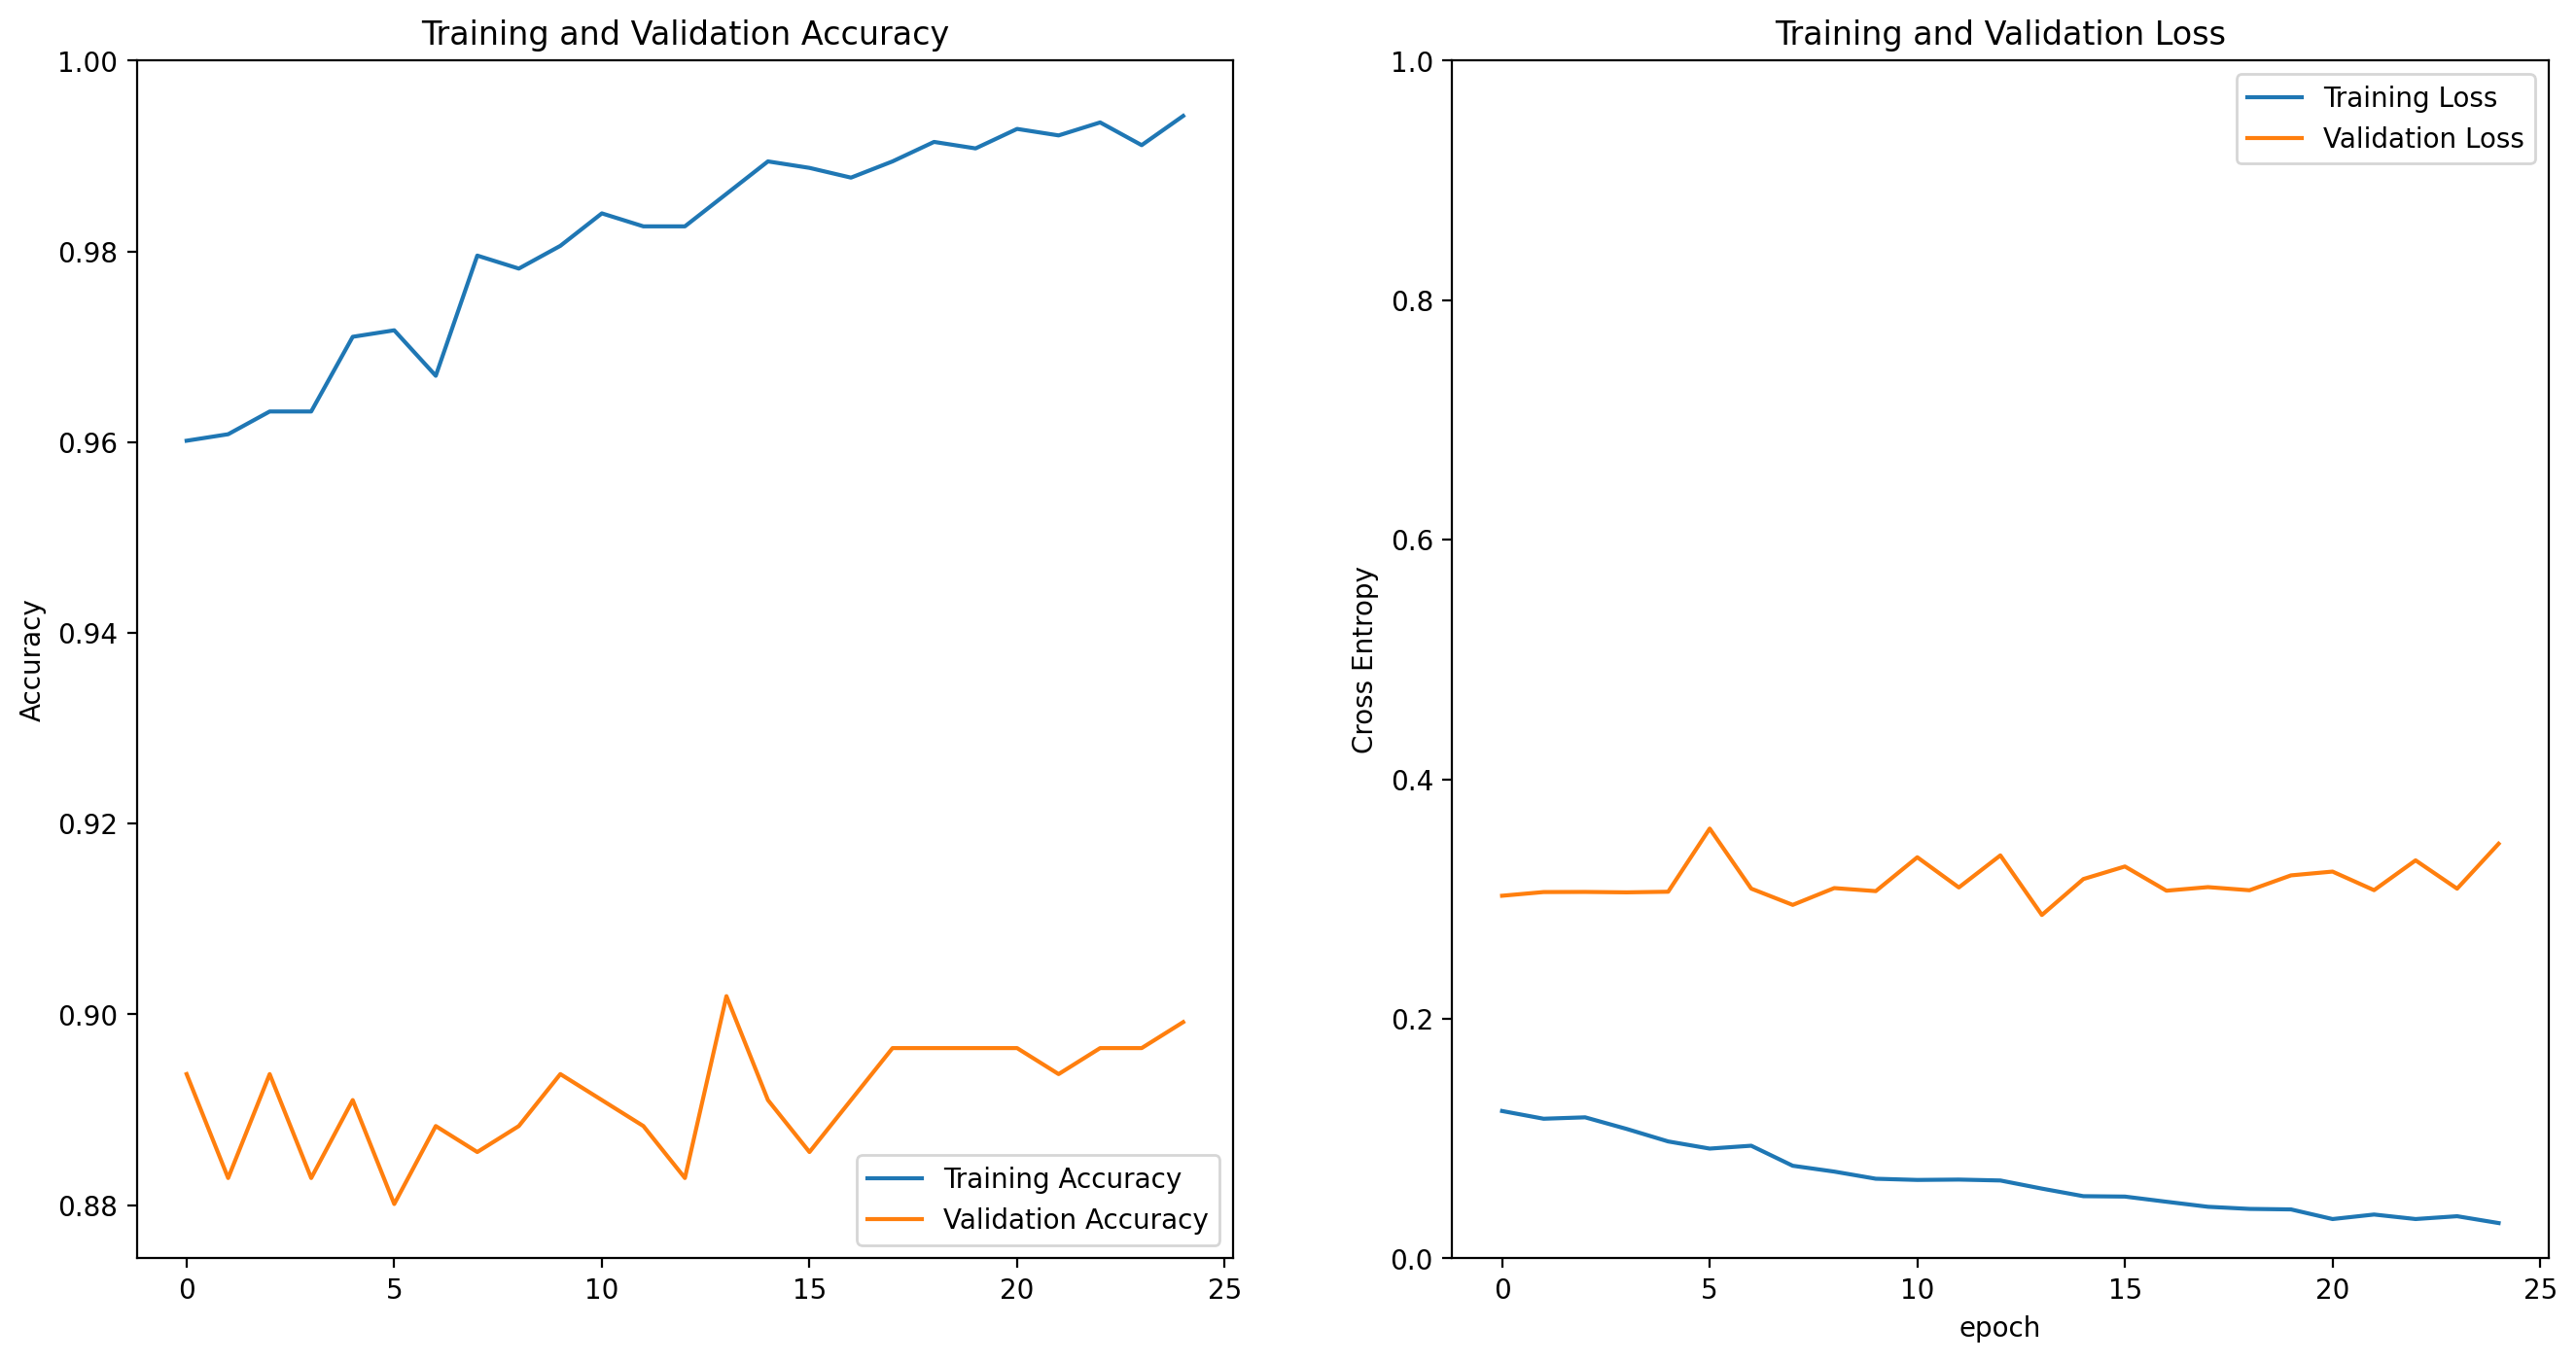

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[5.13907382e-03, 2.76372075e-01, 2.89116949e-01, 1.57716367e-02,
        4.13600296e-01],
       [1.00000000e+00, 4.82914542e-10, 3.56809721e-10, 1.67431222e-10,
        7.09914558e-11],
       [9.98328745e-01, 3.60137521e-04, 4.38122661e-05, 1.10021827e-03,
        1.67128484e-04],
       [3.24055054e-06, 7.54851935e-05, 9.79790092e-01, 7.98218753e-06,
        2.01232061e-02],
       [9.99786973e-01, 9.91297202e-05, 8.43106100e-05, 1.45524118e-05,
        1.50566975e-05],
       [9.99999881e-01, 1.68682220e-07, 8.54801452e-10, 3.74883280e-09,
        5.36291067e-10],
       [2.26224256e-05, 1.93906552e-03, 9.97678220e-01, 7.38055860e-06,
        3.52744682e-04],
       [1.22165233e-07, 9.99999166e-01, 9.56341430e-12, 7.27090196e-07,
        4.19948964e-10],
       [1.15935471e-07, 1.04872690e-11, 2.55744270e-09, 9.99999881e-01,
        1.24639743e-10],
       [1.00000000e+00, 1.90814813e-08, 4.80111817e-09, 8.69763195e-09,
        3.70187186e-10],
       [1.00000000e+00, 4.8701

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

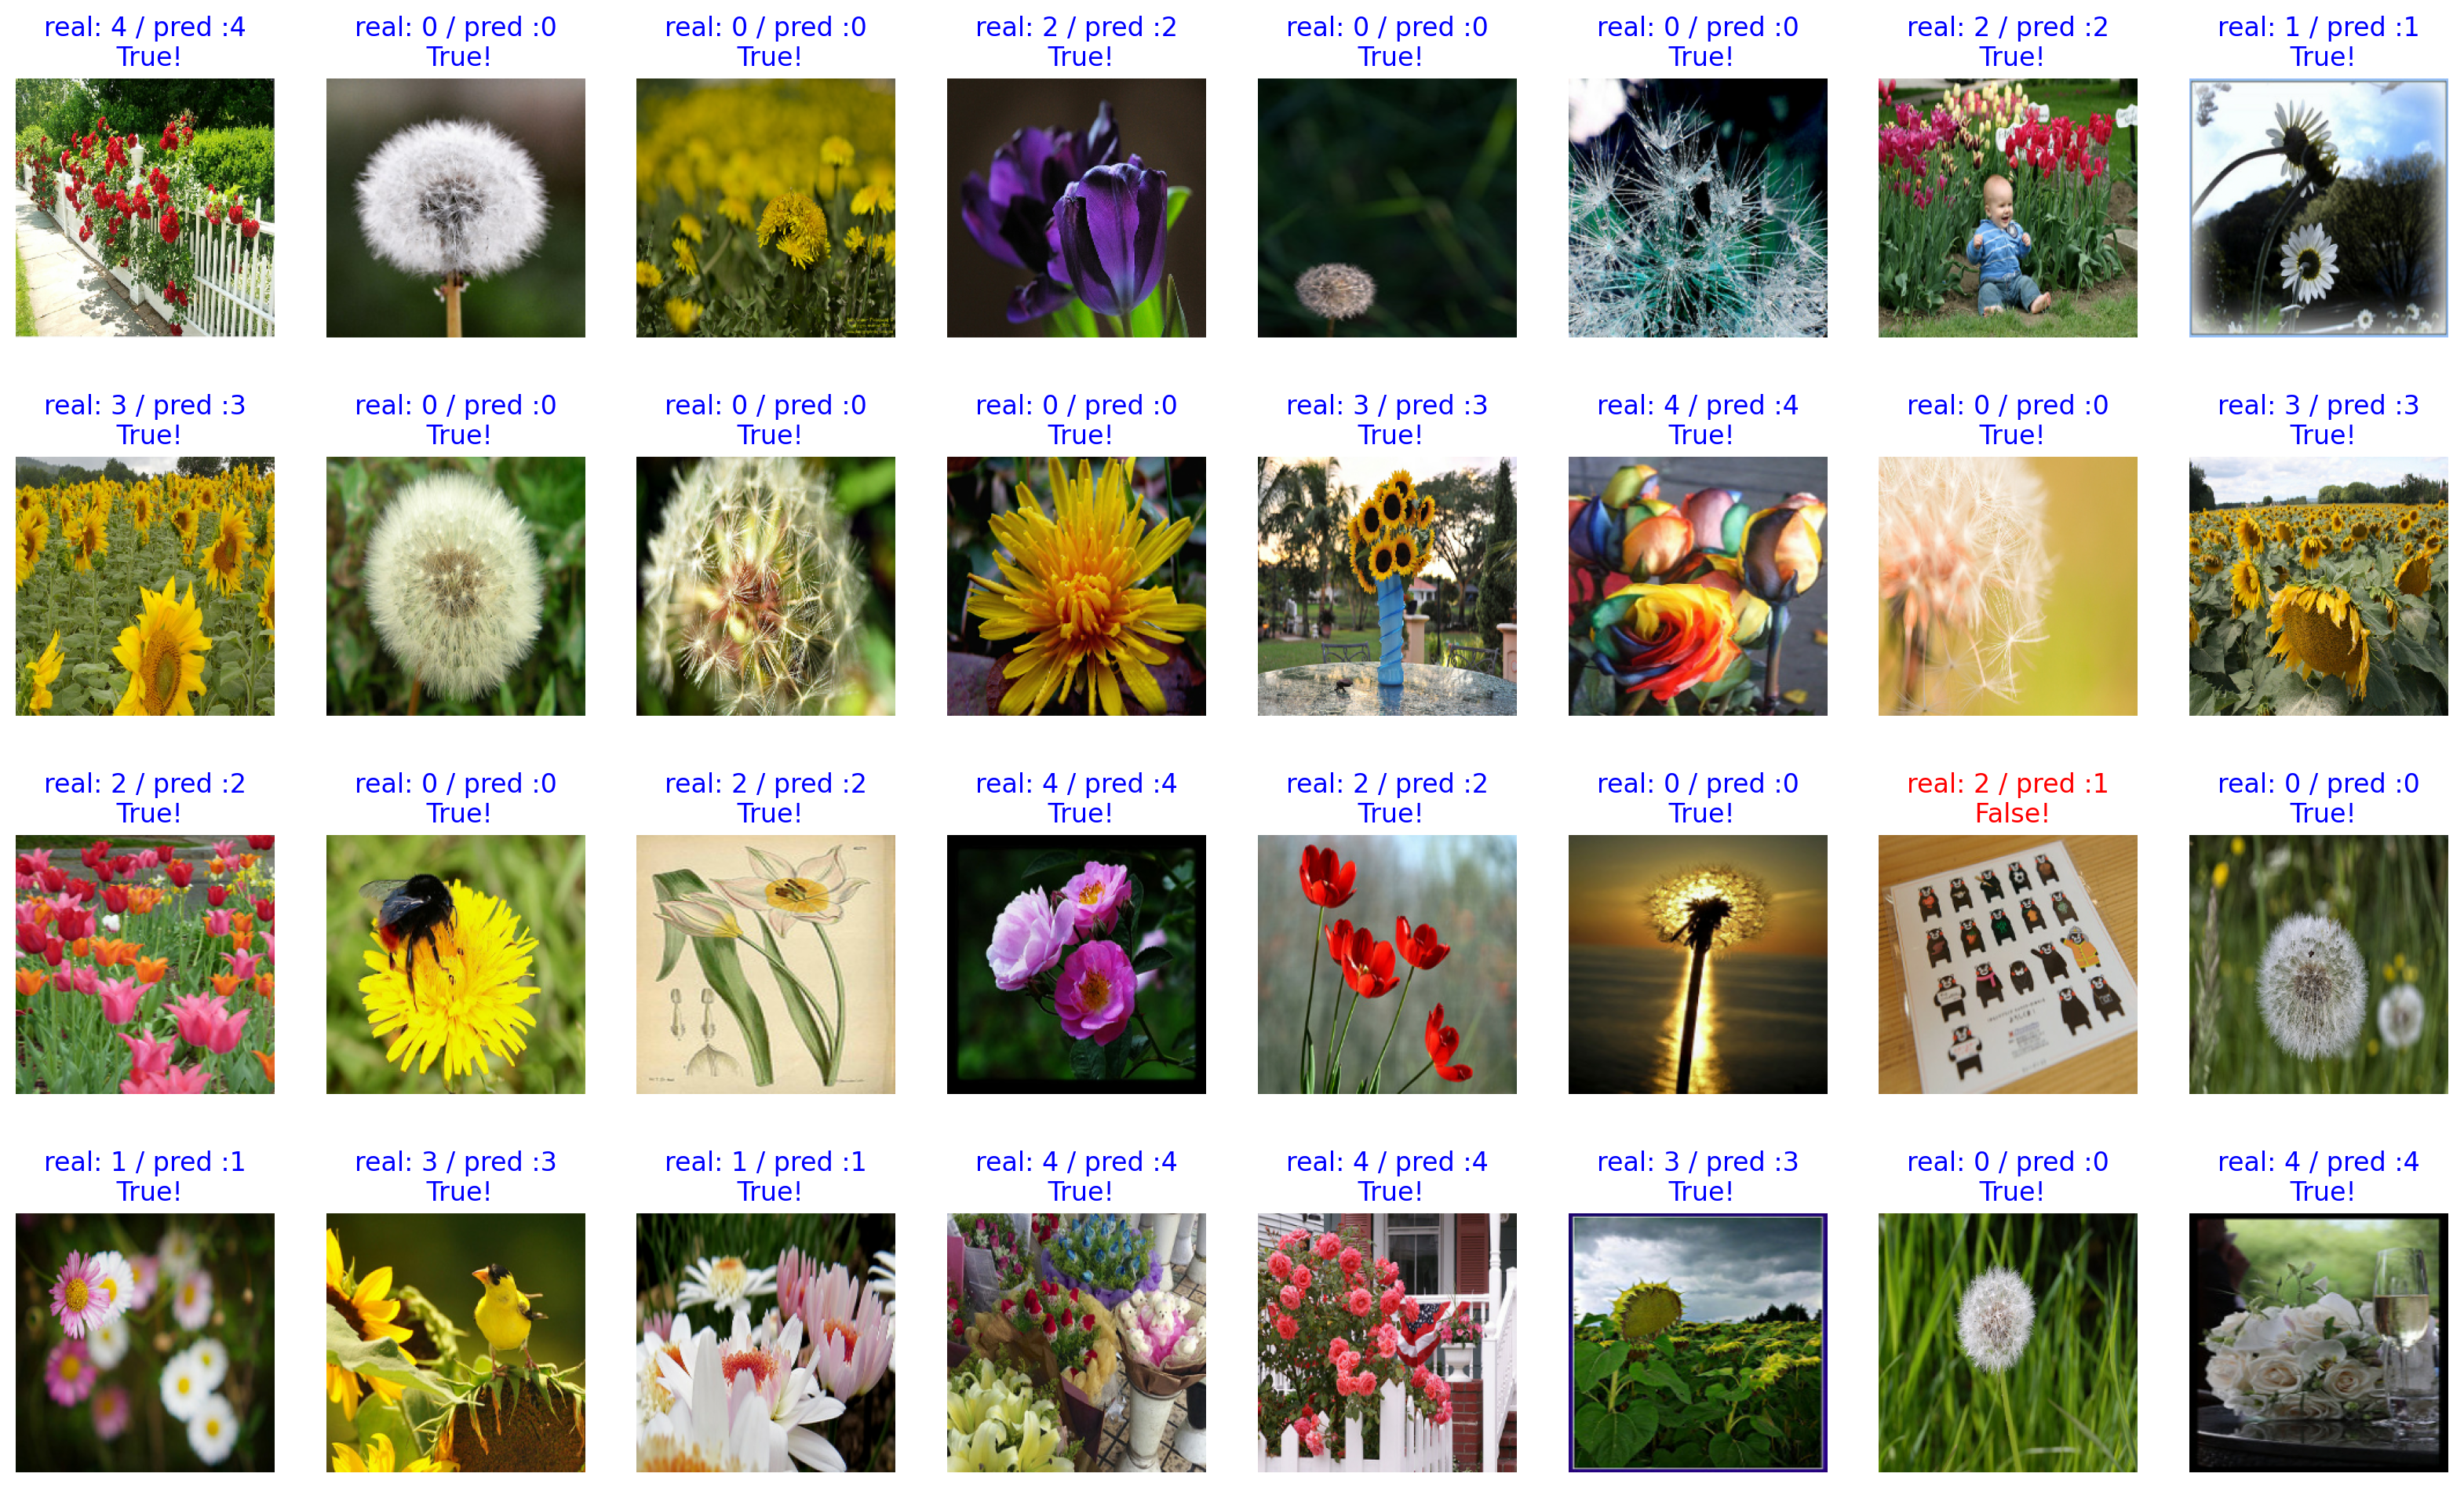

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [ ]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

96.875


In [ ]:
!mkdir -p ./content/checkpoint
!mkdir -p ./content/images